In [1]:
import cv2
import numpy as np
import pandas as pd
from scipy import interpolate

import datajoint as dj
import static_nda as nda
from pipeline import meso, experiment, treadmill
pupil = dj.create_virtual_module('pipeline_eye','pipeline_eye')
# eye = dj.create_virtual_module('pipeline_eye','pipeline_eye')

import matplotlib.pyplot as plt
from matplotlib.patches import Circle,Ellipse




Loading local settings from pipeline_config.json
Connecting pfahey@at-database.ad.bcm.edu:3306


In [11]:
def fetch_pupil(key, method = "Circle"):
    '''
    Return pupil center, pupil radius, pupil video and a function to interpolate 
    from behavior times to pupil trace idx
    '''
    scan_filenames = (experiment.Scan & key).local_filenames_as_wildcard
    pupil_video_file = scan_filenames.split('*')[0] + "_beh.avi"
    pupil_video = cv2.VideoCapture(pupil_video_file)
    fetch_str = ['major_radius','minor_radius','rotation_angle','center']
    if method == "Ellipse":
        major_rs,minor_rs,angles, pupil_centers = (pupil.FittedPupil.Ellipse & key & 'tracking_method=2').fetch(*fetch_str)
        params = (major_rs,minor_rs,angles)
    elif method == "Circle":
        pupil_radii, pupil_centers = (pupil.FittedPupil.Circle & key & 'tracking_method=2').fetch('radius','center', 
                                                                                order_by='frame_id ASC')
        params = (pupil_radii)
        
    pupil_centers = np.array([p if p is not None else np.array([np.nan, np.nan]) for p in pupil_centers])
    pupil_center_x = pupil_centers[:, 0]
    pupil_center_y = pupil_centers[:, 1]

    # pupil centers stored in the FittedPupil table is the location of the pupil center in the cropped eye video
    # recover original position by adding crop ROI corner
    crop_x0, crop_y0 = (pupil.Tracking.Deeplabcut & key).fetch1('cropped_x0', 'cropped_y0')
    pupil_center_x = pupil_center_x + crop_x0
    pupil_center_y = pupil_center_y + crop_y0

    eye_time = (pupil.Eye & key).fetch1('eye_time')
    beh_time2pupil_idx_float = interpolate.interp1d(eye_time, np.arange(len(eye_time)))
    
    # turn the interpolated value to an int
    beh_time2pupil_idx = lambda x : int(np.round(beh_time2pupil_idx_float(x)))  
    
    return pupil_center_x, pupil_center_y, params, pupil_video, beh_time2pupil_idx, eye_time
    
def plot_pupil_frame2(beh_time, beh_time2pupil_idx, 
                      pupil_center_x, pupil_center_y, 
                      params, pupil_video,method = "Circle"):
    
    # plot pupil frame
    fig,axes = plt.subplots(1,2,figsize=(25,10))
    pupil_frame_idx = beh_time2pupil_idx(np.array([beh_time]))
    pupil_video.set(1, pupil_frame_idx)
    ret, pupil_frame = pupil_video.read()
    pupil_frame = np.flip(pupil_frame,axis=(0,1))
    ymax,xmax = np.shape(pupil_frame)[:2]
    
    for ax in axes:
        ax.imshow(pupil_frame,cmap='gray')#,
#                   vmin=np.percentile(pupil_frame,1),
#                   vmax=np.percentile(pupil_frame,99))
        if pupil_center_x[pupil_frame_idx] is not None:
            ax.scatter(xmax-pupil_center_x[pupil_frame_idx], 
                       ymax-pupil_center_y[pupil_frame_idx], 
                       s=50, c='red', marker='.', clip_on=False, linewidth=.5)
        ax.set_xticks([])
        ax.set_yticks([])
    
    if pupil_center_x[pupil_frame_idx] is not None:
        if method == "Ellipse":
            major_rs,minor_rs,angles=params
            pupil_circ = Ellipse(
                [xmax-pupil_center_x[pupil_frame_idx], 
                 ymax-pupil_center_y[pupil_frame_idx]],
                minor_rs[pupil_frame_idx]*2,
                major_rs[pupil_frame_idx]*2,
                angles[pupil_frame_idx],
                edgecolor='red', 
                facecolor=None, 
                fill=False
            )
        elif method == "Circle":
            pupil_radii = params
            pupil_circ = Circle(
                [xmax-pupil_center_x[pupil_frame_idx], 
                 ymax-pupil_center_y[pupil_frame_idx]],
                radius = pupil_radii[pupil_frame_idx],
                edgecolor='red', 
                facecolor=None, 
                fill=False
            )
        
        axes[1].add_patch(pupil_circ)
    plt.suptitle('_'.join([str(s) for s in [scan['animal_id'],scan['session'],scan['scan_idx']]])+
                 f'\nbeh time: {beh_time}' +
                 f'\nvideo frame: {pupil_frame_idx}' +
                 f'\npupil_x: {pupil_center_x[pupil_frame_idx]:.2f}' +
                 f'\npupil_y: {pupil_center_y[pupil_frame_idx]:.2f}')
    
    plt.show()
    plt.close()
        
                
        
    

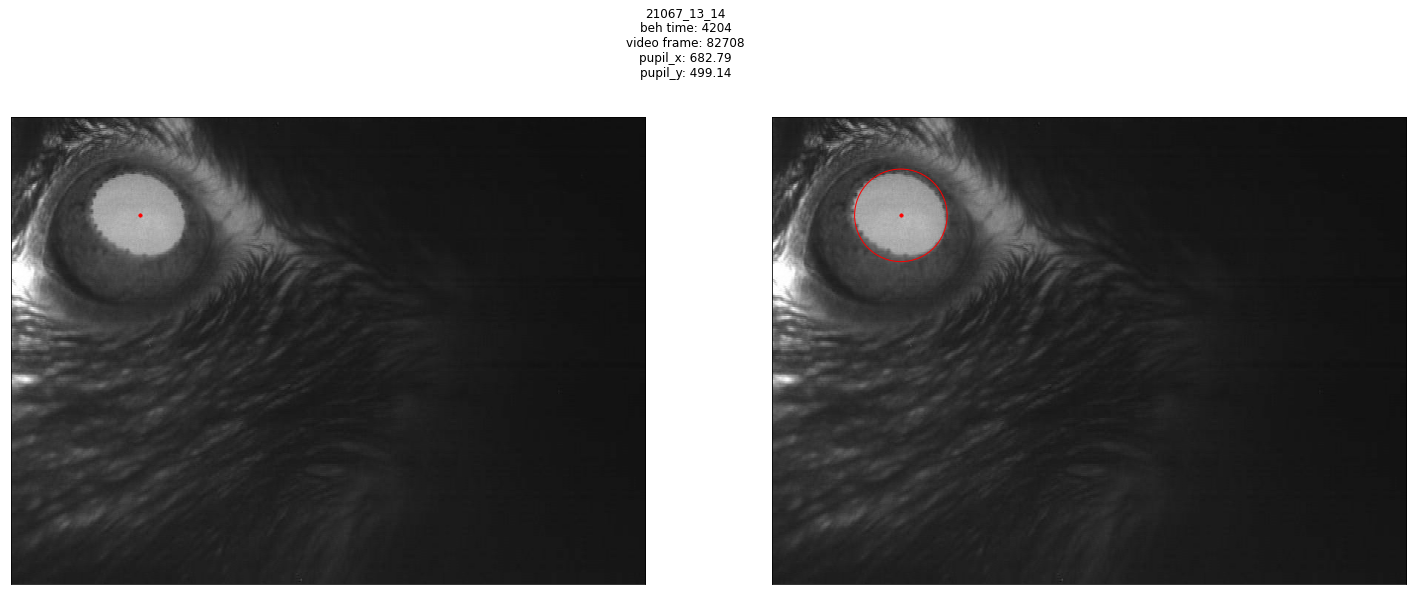

In [12]:
scan = {'animal_id':21067, 'session':13, 'scan_idx':14}
beh_time = 4204
pupil_center_x, pupil_center_y, params, pupil_video, beh_time2pupil_idx, eye_time = fetch_pupil(scan)
plot_pupil_frame2(beh_time, beh_time2pupil_idx, pupil_center_x, pupil_center_y, params, pupil_video)    

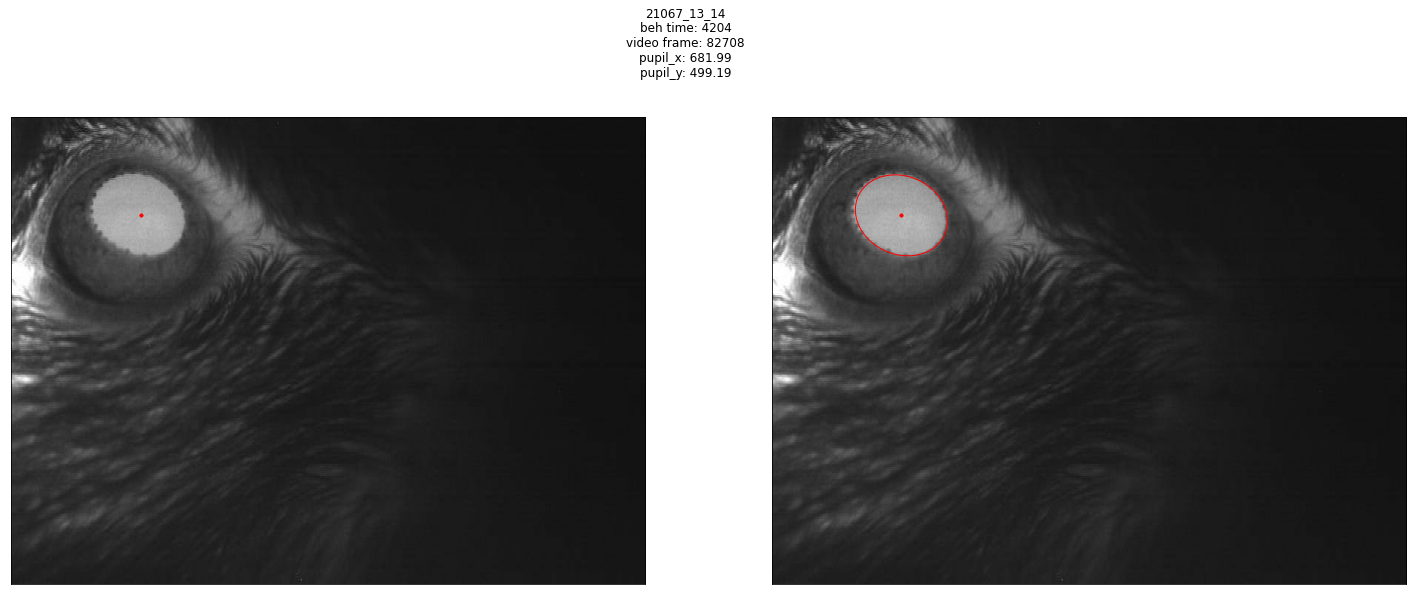

In [13]:
scan = {'animal_id':21067, 'session':13, 'scan_idx':14}
beh_time = 4204
pupil_center_x, pupil_center_y, params, pupil_video, beh_time2pupil_idx, eye_time = fetch_pupil(scan,method="Ellipse")
plot_pupil_frame2(beh_time, beh_time2pupil_idx, pupil_center_x, pupil_center_y, params, pupil_video,method="Ellipse")    

In [ ]:
# for scan in nda.Scan():
#     pupil_center_x, pupil_center_y, major_rs,minor_rs,angles, pupil_video, beh_time2pupil_idx, eye_time = fetch_pupil(scan)
#     for beh_time in np.round(np.linspace(np.nanpercentile(eye_time,10),
#                                          np.nanpercentile(eye_time,80),5)).astype(int):
#         plot_pupil_frame2(beh_time, beh_time2pupil_idx, pupil_center_x, pupil_center_y, major_rs,minor_rs,angles, pupil_video)


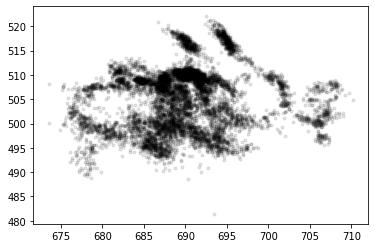

In [81]:
i,j = 100000,10000
plt.plot(pupil_center_x[i:i+j],pupil_center_y[i:i+j],'.k',alpha=0.1)

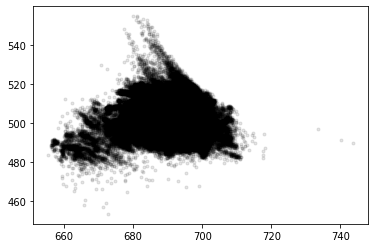

In [75]:
plt.plot(pupil_center_x,pupil_center_y,'.k',alpha=0.1)